In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [93]:
dados = pd.read_csv("data/ca.csv")

C:\Users\kaio\AppData\Local\Temp\ipykernel_28684\2499396848.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv("data/ca.csv")


In [94]:

# Mostra o nome das colunas
print("Nomes das colunas:")
print(dados.columns)

Nomes das colunas:
Index(['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira'],
      dtype='object')


In [95]:
# Verificando quais colunas contêm valores nulos
colunas_nulas = dados.isnull().sum()

# Filtrando para mostrar apenas as colunas que têm valores nulos
colunas_com_nulos = colunas_nulas[colunas_nulas > 0]

print("Colunas com valores nulos:")
print(colunas_com_nulos)

Colunas com valores nulos:
Numero Rua            605
Complemento        579320
Bairro               1176
Valor de Compra    740945
dtype: int64


In [96]:
dados['Estado - Sigla'].value_counts()

Estado - Sigla
BA    240700
CE    159862
PE    132842
MA     77758
RN     54326
PB     52367
PI     51767
AL     47837
SE     34418
Name: count, dtype: int64

## Pre-Processamento

In [97]:
print("tamanho dos dados antes do pre-processamento:",len(dados))
dados.head(5)


tamanho dos dados antes do pre-processamento: 851877


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,GASOLINA,02/01/2019,"4,49",NaN,R$ / litro,BRANCA
1,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,ETANOL,02/01/2019,"3,33",NaN,R$ / litro,BRANCA
2,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL,02/01/2019,"3,3",NaN,R$ / litro,BRANCA
3,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL S10,02/01/2019,"3,4",NaN,R$ / litro,BRANCA
4,NE,AL,ARAPIRACA,POSTO ARAPIRACA LTDA,12.451.076/0001-12,RUA EXPEDICIONARIOS BRASILEIROS,252,NaN,CENTRO,57300-590,GASOLINA,02/01/2019,"4,699","3,8906",R$ / litro,PETROBRAS DISTRIBUIDORA S.A.


In [98]:
dados['Data da Coleta'] = pd.to_datetime(dados['Data da Coleta'], format='%d/%m/%Y')
dados['Valor de Venda'] = dados['Valor de Venda'].str.replace(',', '.', regex=False).astype(float)
dados = dados[dados['Produto'] == 'GASOLINA']
dados = dados[dados['Estado - Sigla'] == 'CE']
dados = dados[dados['Municipio'] == 'FORTALEZA']

dados.set_index('Data da Coleta', inplace=True)

dados['Ano'] = dados.index.year.astype(float)

dados['Mes'] = dados.index.month.astype(float)

dados = dados.drop(columns=['Valor de Compra'])
dados = dados.drop(columns=['Numero Rua'])
dados = dados.drop(columns=['Complemento'])
dados = dados.drop(columns=['CNPJ da Revenda'])


dados.head()


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,Nome da Rua,Bairro,Cep,Produto,Valor de Venda,Unidade de Medida,Bandeira,Ano,Mes
Data da Coleta,,,,,,,,,,,,,
2019-01-02,NE,CE,FORTALEZA,DIAS COMERCIO DE DERIVADOS DE PETROLEO LTDA,RODOVIA DOUTOR MENDEL STEINBRUCH,ARACAPE,60765-005,GASOLINA,4.170,R$ / litro,RAIZEN,2019.0,1.0
2019-01-02,NE,CE,FORTALEZA,JOCKEY COMÉRCIO DE COMBUSTÍVEIS LTDA.,AVENIDA LINEU MACHADO,PICI,60520-380,GASOLINA,4.250,R$ / litro,IPIRANGA,2019.0,1.0
2019-01-02,NE,CE,FORTALEZA,F.P. PETROLEO EIRELI,AVENIDA PRESIDENTE COSTA E SILVA,PASSARÉ,60761-190,GASOLINA,4.260,R$ / litro,SP,2019.0,1.0
2019-01-02,NE,CE,FORTALEZA,CENTRO EMPRESARIAL DRA ZUILA ALENCAR BARREIRA ...,AVENIDA JOSE BASTOS,DAMAS,60020-292,GASOLINA,4.240,R$ / litro,IPIRANGA,2019.0,1.0
2019-01-02,NE,CE,FORTALEZA,GG-KIKO COMERCIAL DE COMBUSTIVEIS E SERVIÇOS LTDA,AVENIDA I,CONJUNTO CEARA,60533-670,GASOLINA,4.199,R$ / litro,SP,2019.0,1.0


In [99]:
dados['Municipio'].value_counts()

# Municipios que possuem alto valor
# - ITAPIPOCA
# - CANINDE
# - CRATEUS


Municipio
FORTALEZA    21713
Name: count, dtype: int64

In [100]:
# Manter apenas as colunas 'Municipio' e 'Valor de Venda'
dados = dados[['Municipio', 'Valor de Venda']]
print(len(dados))

# Filtrar os dados para incluir apenas os municípios de Crato, Juazeiro e Barbalha
municipios_desejados = ['MARACANAU', 'FORTALEZA','CAUCAIA']
dados = dados[dados['Municipio'].isin(municipios_desejados)]

# Reamostrar os dados semanalmente, alinhando as datas ao início do intervalo
dados = dados.groupby('Municipio').resample('W-MON', label='left').mean()

# Preencher os valores NaN com o valor anterior para evitar perda de dados
dados = dados.groupby('Municipio').fillna(method='ffill')

# Resetar o índice e reconfigurar a 'Data da Coleta' como índice
dados = dados.reset_index()
dados.set_index('Data da Coleta', inplace=True)

# Ordenar os dados pelo índice
dados = dados.sort_index()

# Adicionar as colunas 'Ano' e 'Mes'
dados['Ano'] = dados.index.year.astype(float)
dados['Mes'] = dados.index.month.astype(float)


21713


C:\Users\kaio\AppData\Local\Temp\ipykernel_28684\3256400274.py:13: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados = dados.groupby('Municipio').fillna(method='ffill')
C:\Users\kaio\AppData\Local\Temp\ipykernel_28684\3256400274.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados = dados.groupby('Municipio').fillna(method='ffill')


In [101]:
dados['Municipio'].value_counts()

Municipio
FORTALEZA    261
Name: count, dtype: int64

In [102]:
print("tamanho dos dados após pre-processamento:",len(dados))
dados.head(5)

tamanho dos dados após pre-processamento: 261


,Municipio,Valor de Venda,Ano,Mes
Data da Coleta,,,,
2018-12-31,FORTALEZA,4.293604,2018.0,12.0
2019-01-07,FORTALEZA,4.216802,2019.0,1.0
2019-01-14,FORTALEZA,4.216802,2019.0,1.0
2019-01-21,FORTALEZA,4.172050,2019.0,1.0
2019-01-28,FORTALEZA,4.126631,2019.0,1.0


In [103]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Definindo colunas categóricas e numéricas
categorical_features = ['Municipio']
numeric_features = ['Ano', 'Mes','Valor de Venda']

# Separando as features e o target
X = dados[categorical_features + numeric_features]
y = dados['Valor de Venda']

# Determinando os tamanhos dos conjuntos de treino, validação e teste
n = len(X)
train_size = int(n * 0.72)  # 72% para treino
val_size = int(n * 0.18)    # 18% para validação
test_size = n - train_size - val_size  # 10% para teste

# Dividindo os dados
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Configurando o pré-processador para aplicar OneHotEncoding apenas nas colunas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Mantém as features numéricas na escala original
)

# Criando o pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicando o pipeline aos dados de treino e transformando
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)

# Obtendo os nomes das colunas após o OneHotEncoding e mantendo as colunas numéricas
categorical_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_feature_names = list(categorical_feature_names) + numeric_features

# Convertendo as matrizes para DataFrames e ajustando os índices para frequência diária
X_train_transformed_df = pd.DataFrame(X_train_transformed, 
                                      columns=all_feature_names,
                                      index=X_train.index)

X_val_transformed_df = pd.DataFrame(X_val_transformed, 
                                    columns=all_feature_names,
                                    index=X_val.index)

X_test_transformed_df = pd.DataFrame(X_test_transformed, 
                                     columns=all_feature_names,
                                     index=X_test)

# Verificando os tamanhos dos conjuntos e o ajuste de índices
print("Treinamento:", X_train_transformed_df.shape)
print("Validação:", X_val_transformed_df.shape)
print("Teste:", X_test_transformed_df.shape)

'''# Adicionando a coluna 'Valor de Venda' aos dados de treino e validação originais
dados_treino = X_train.copy()
dados_val = X_val.copy()

dados_treino['Valor de Venda'] = y_train
dados_val['Valor de Venda'] = y_val'''


Treinamento: (187, 4)
Validação: (46, 4)
Teste: (28, 4)


"# Adicionando a coluna 'Valor de Venda' aos dados de treino e validação originais\ndados_treino = X_train.copy()\ndados_val = X_val.copy()\n\ndados_treino['Valor de Venda'] = y_train\ndados_val['Valor de Venda'] = y_val"

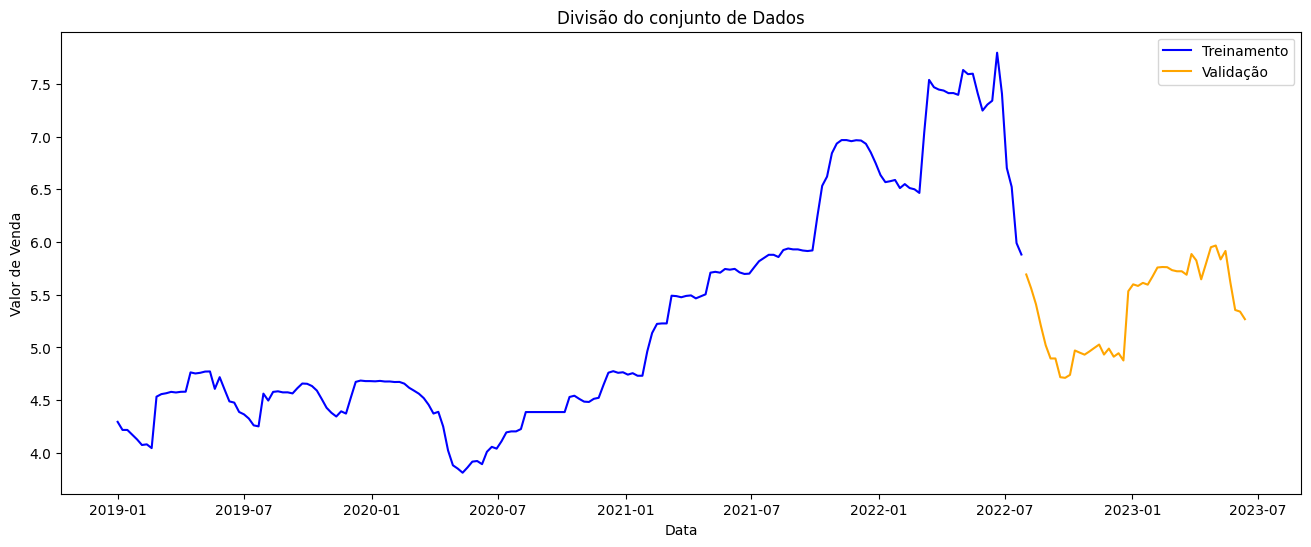

In [104]:
plt.figure(figsize=(16,6))

plt.title("Divisão do conjunto de Dados")

plt.plot(y_train,label='Treinamento', color='blue')
plt.plot(y_val,label='Validação', color='orange')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()

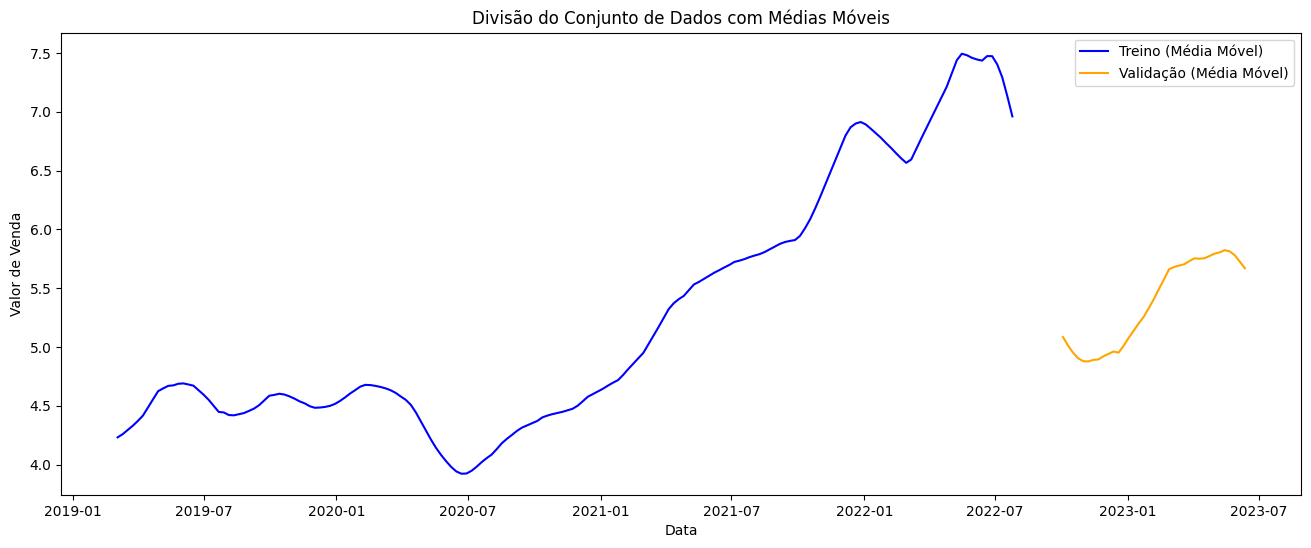

In [105]:
# Aplicando médias móveis com uma janela de 10 períodos (por exemplo)
y_train_rolling = y_train.rolling(window=10).mean()
y_val_rolling = y_val.rolling(window=10).mean()

# Plotando as médias móveis
plt.figure(figsize=(16, 6))

plt.title("Divisão do Conjunto de Dados com Médias Móveis")

plt.plot(y_train_rolling, label='Treino (Média Móvel)', color='blue')
plt.plot(y_val_rolling, label='Validação (Média Móvel)', color='orange')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()


# log linear e usar linear 
# depois pegar o residuo do modelo linear e usar na arvore de decisao

## Análise de Autocorrelação

<function matplotlib.pyplot.show(close=None, block=None)>

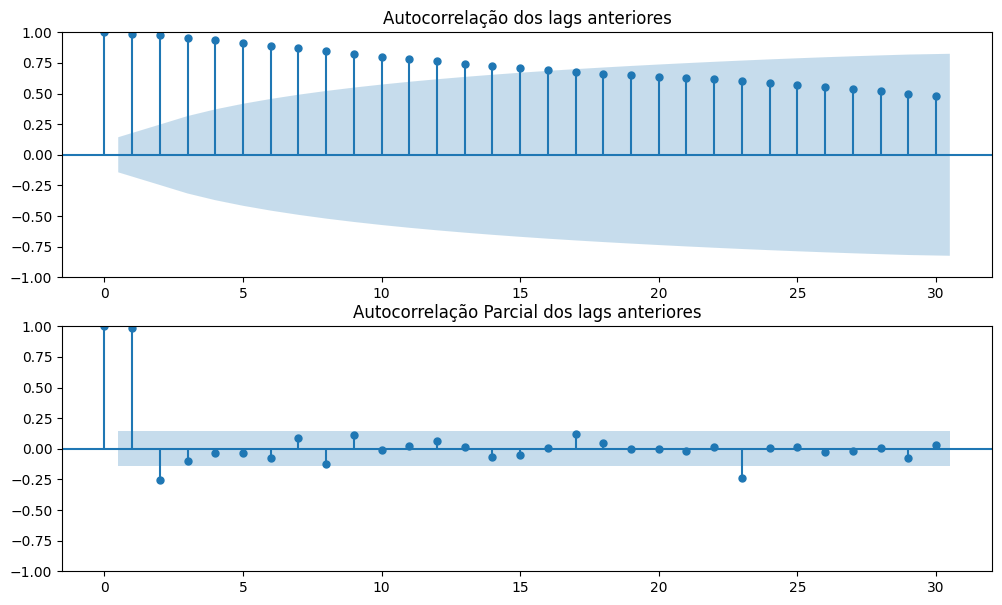

In [106]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(X_train['Valor de Venda'], lags=30, ax=ax1)
ax1.set_title("Autocorrelação dos lags anteriores")

ax2 = fig.add_subplot(212)
fig = plot_pacf(X_train['Valor de Venda'], lags=30, ax=ax2)
ax2.set_title("Autocorrelação Parcial dos lags anteriores")

plt.show


Lags Significantes: [1, 2, 6, 7, 8, 9, 17, 23, 28]


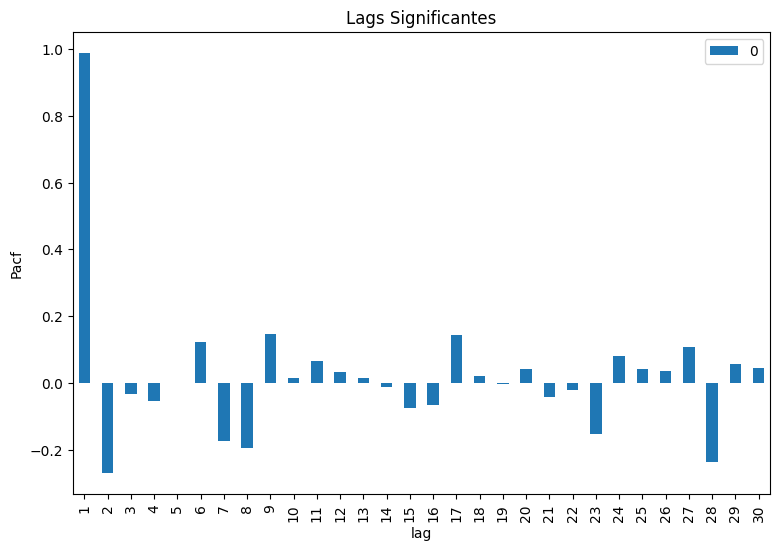

In [107]:
from statsmodels.tsa.stattools import pacf

def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(Pacf)[1:].plot(kind='bar', figsize=(9,6), legend='pacf valores',
                               xlabel='lag', ylabel='Pacf');
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    print('Lags Significantes:', significantLags)
    return significantLags

DT_significantLags = getSignificantLags(dados['Valor de Venda'], nLags = 30, alpha=0.05)
plt.title("Lags Significantes")
plt.show()

## Modelagem

In [108]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
def TheilU(y_true, y_pred):
    fResiduals2 = y_true[1:].subtract(y_pred[1:])
    fResiduals2 = fResiduals2.multiply(fResiduals2)
    rwForecasts = y_true.shift(1)
    rwResiduals2 = y_true[1:].subtract(rwForecasts[1:])
    rwResiduals2 = rwResiduals2.multiply(rwResiduals2)
    theil = fResiduals2.sum()/rwResiduals2.sum()
    return theil

models_label_r = []
df_teste  = pd.DataFrame()
def ResidualForModels(models,y_pred): 
    for model in models:
        formalism = type(model).__name__
        models_label_r.append(formalism)
        y_pred_t = y_pred
        df_teste[formalism] = y_pred_t
    return df_teste

models_label = []
models_MAPE = []
models_MAE = []
models_R2 = []
models_theil = []

def computeAccuracyModels(models,y_pred): 
    for model in models:
        formalism = type(model).__name__
        models_label.append(formalism)
        y_pred_test = y_pred
        models_MAE.append(mean_absolute_error(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        # models_theil.append(TheilU(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        models_MAPE.append(mean_absolute_percentage_error(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        models_R2.append(r2_score(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        
    df = pd.DataFrame({'model': models_label, 
                       'MAE': models_MAE,
                       'MAPE': models_MAPE,
                       'R2': models_R2,
                       # 'theil': models_theil
                       })
    print(" --------------------------- Medidas de Erro para os Modelos  --------------------------- ") 
    print(df.sort_values(by='MAE', ascending = True))
    

In [109]:
def appendLagVariables(y, significantLags, df, dropna=True, previousData=None):
    prefix = y.replace(')', '')
    df = df.copy()  # Fazendo uma cópia para evitar modificar o original
    lowerIndex = 0
    x = df[y]
    
    if previousData is not None:
        x = pd.concat([previousData[y], x])
        lowerIndex = previousData.shape[0]
    
    for lag in significantLags:
        varNm = prefix + '-' + str(lag) + ')'
        df[varNm] = x.shift(lag)[lowerIndex:]
    
    if dropna:
        # Dropar apenas linhas onde os NaN estão nas colunas de lag, preservando a coluna 'Valor de Venda'
        lag_columns = [prefix + '-' + str(lag) + ')' for lag in significantLags]
        df.dropna(subset=lag_columns, inplace=True)
        
    return df

# Usar a função para gerar as variáveis de lag e atribuir ao DataFrame X_train_transformed_df
X_train_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_train_transformed_df, 
    dropna=True
)

X_val_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_val_transformed_df, 
    dropna=True
)

X_test_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_test_transformed_df, 
    dropna=True
)

X_val = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_val, 
    dropna=True
)

y_train = X_train_transformed_df['Valor de Venda']
y_val = X_val_transformed_df['Valor de Venda']
y_test = X_test_transformed_df['Valor de Venda']



X_val_transformed_df = X_val_transformed_df.drop(columns=['Valor de Venda'])
X_test_transformed_df = X_test_transformed_df.drop(columns=['Valor de Venda'])
X_train_transformed_df = X_train_transformed_df.drop(columns=['Valor de Venda'])


In [110]:
print("Tamanho do dados após o pipeline\n")
print("Treinamento:", len(X_train_transformed_df))
print("Validação:", len(X_val_transformed_df))

Tamanho do dados após o pipeline

Treinamento: 159
Validação: 18


* trabalhar somente com fortaleza
* usar arvore de decisao para modelar residuos de outros modelos

In [111]:
X_val_transformed_df.head(5)

,Municipio_FORTALEZA,Ano,Mes,Valor de Venda-1),Valor de Venda-2),Valor de Venda-6),Valor de Venda-7),Valor de Venda-8),Valor de Venda-9),Valor de Venda-17),Valor de Venda-23),Valor de Venda-28)
Data da Coleta,,,,,,,,,,,,
2023-02-13,1.0,2023.0,2.0,5.758276,5.673922,5.598387,5.533400,4.875957,4.944615,4.950375,4.895051,5.692043
2023-02-20,1.0,2023.0,2.0,5.762857,5.758276,5.583404,5.598387,5.533400,4.875957,4.931143,4.895051,5.561061
2023-02-27,1.0,2023.0,2.0,5.761250,5.762857,5.612500,5.583404,5.598387,5.533400,4.961628,4.717333,5.409065
2023-03-06,1.0,2023.0,3.0,5.733220,5.761250,5.595345,5.612500,5.583404,5.598387,4.994857,4.711132,5.206753
2023-03-13,1.0,2023.0,3.0,5.722500,5.733220,5.673922,5.595345,5.612500,5.583404,5.027059,4.739231,5.020621


# Regression Linear Model

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Definição do modelo
model_lr = {
    'Linear Regression': LinearRegression()
}

# Definição da grade de parâmetros
param_grids_lr = {
    'Linear Regression': {
        'fit_intercept': [True, False]
    }
}

# Definição do GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grids_lr['Linear Regression'],
    scoring='r2',  # Usando R² como métrica de avaliação
    cv=5,  # Número de folds para validação cruzada
    n_jobs=-1  # Utilizar todos os núcleos do processador
)

# Ajuste do modelo
grid_search_lr.fit(X_train_transformed_df, y_train)

# Previsões com o melhor estimador
y_pred_lr = grid_search_lr.best_estimator_.predict(X_val_transformed_df)
y_val_series = y_val.values.ravel()  # Convertendo y_val para um array 1D

# Cálculo do MSE (Mean Squared Error)
mse = mean_squared_error(y_val_series, y_pred_lr)
print(f"MSE (Mean Squared Error): {mse}")

# Supondo que a função computeAccuracyModels esteja definida corretamente:
computeAccuracyModels(models=[grid_search_lr.best_estimator_], y_pred=y_pred_lr)



MSE (Mean Squared Error): 0.03203112407401114
 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
              model       MAE      MAPE        R2
0  LinearRegression  0.148004  0.026137  0.189417


In [113]:
df_previsoes = pd.DataFrame({
    'Valor Real': y_val_series,
    'Valor Previsto_LR': y_pred_lr
}, index=y_val.index)

# Supondo que 'Municipio' esteja em X_val
# Adicionando a coluna 'Municipio' ao DataFrame df_comparacao
df_previsoes['Municipio'] = X_val['Municipio']

df_residuos = pd.DataFrame()
df_residuos['resid_LR'] = df_previsoes['Valor Real'].subtract(df_previsoes['Valor Previsto_LR'])
df_residuos['Municipio'] = X_val['Municipio']



In [114]:
display(df_previsoes.head(5))

,Valor Real,Valor Previsto_LR,Municipio
Data da Coleta,,,
2023-02-13,5.762857,6.018076,FORTALEZA
2023-02-20,5.761250,5.858845,FORTALEZA
2023-02-27,5.733220,5.797806,FORTALEZA
2023-03-06,5.722500,5.785644,FORTALEZA
2023-03-13,5.722500,5.769835,FORTALEZA


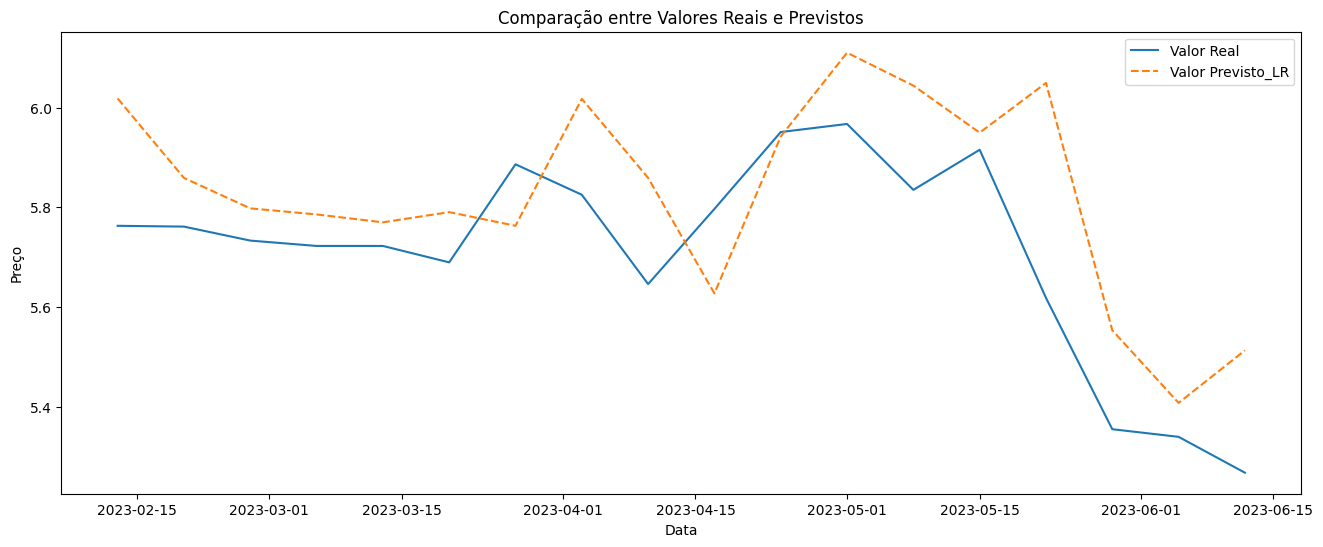

In [115]:
# Plotando os resultados
plt.figure(figsize=(16, 6))
plt.plot(df_previsoes['Valor Real'], label='Valor Real')
plt.plot(df_previsoes['Valor Previsto_LR'], label='Valor Previsto_LR', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

## Residuos do Modelo

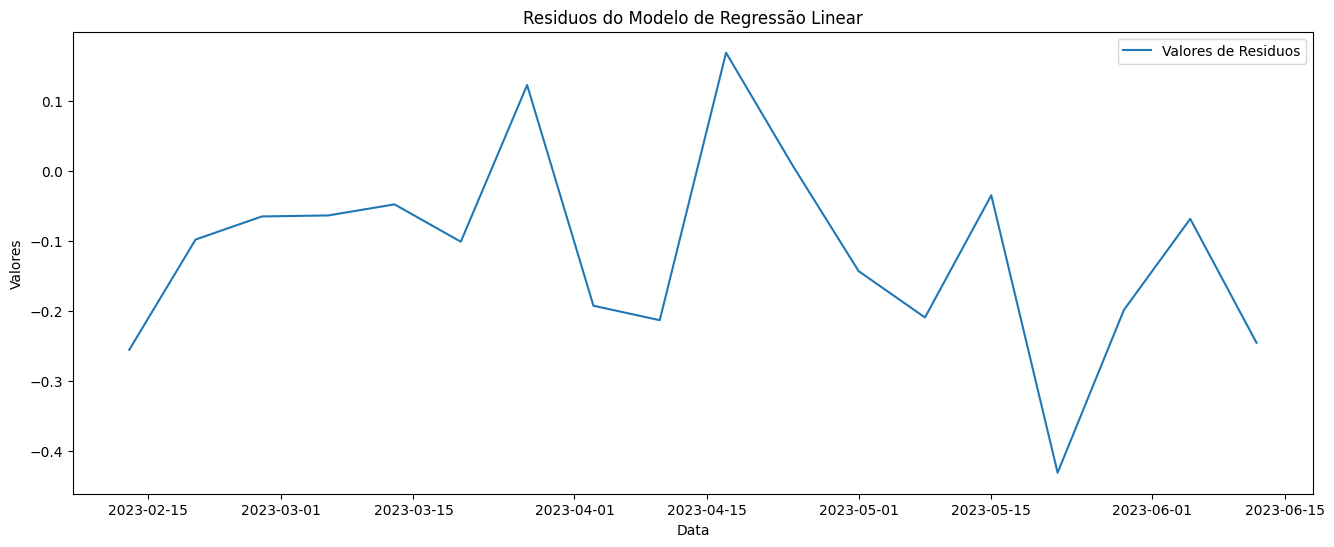

In [116]:
# Plotando os resultados
plt.figure(figsize=(16, 6))
plt.plot(df_residuos['resid_LR'], label='Valores de Residuos')
plt.title('Residuos do Modelo de Regressão Linear')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

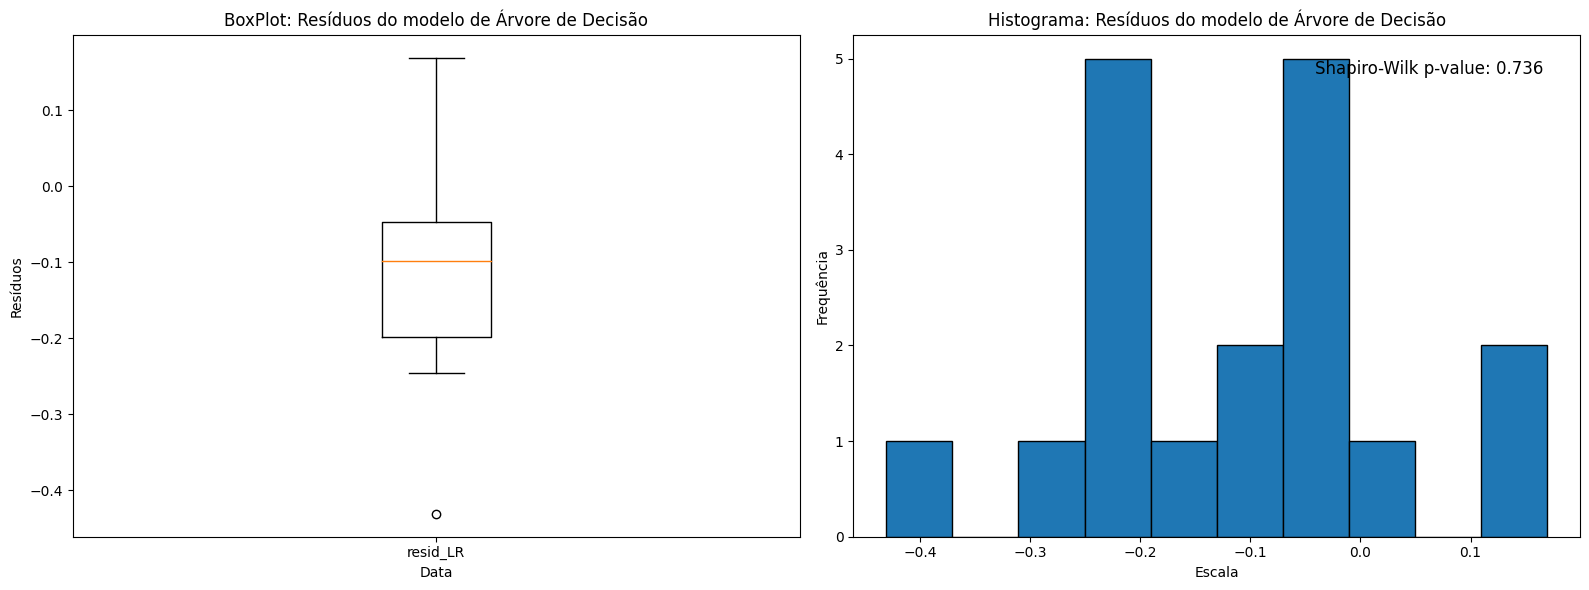

In [117]:
from scipy.stats import shapiro

# Calcular os resíduos

# Criar uma figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotar o boxplot no primeiro subplot
axes[0].boxplot(df_residuos[['resid_LR']].iloc[1:, :], labels=['resid_LR'])
axes[0].set_title("BoxPlot: Resíduos do modelo de Árvore de Decisão")
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Resíduos')

# Plotar o histograma no segundo subplot
df_residuos['resid_LR'].plot(kind='hist', ax=axes[1], edgecolor='black')
axes[1].set_title("Histograma: Resíduos do modelo de Árvore de Decisão")
axes[1].set_xlabel('Escala')
axes[1].set_ylabel('Frequência')

# Realizar o teste de Shapiro-Wilk e adicionar o valor p ao histograma
stat, p_value = shapiro(df_residuos['resid_LR'].dropna())
axes[1].text(0.95, 0.95, f'Shapiro-Wilk p-value: {p_value:.3f}', transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()


## Modelagem dos residuos

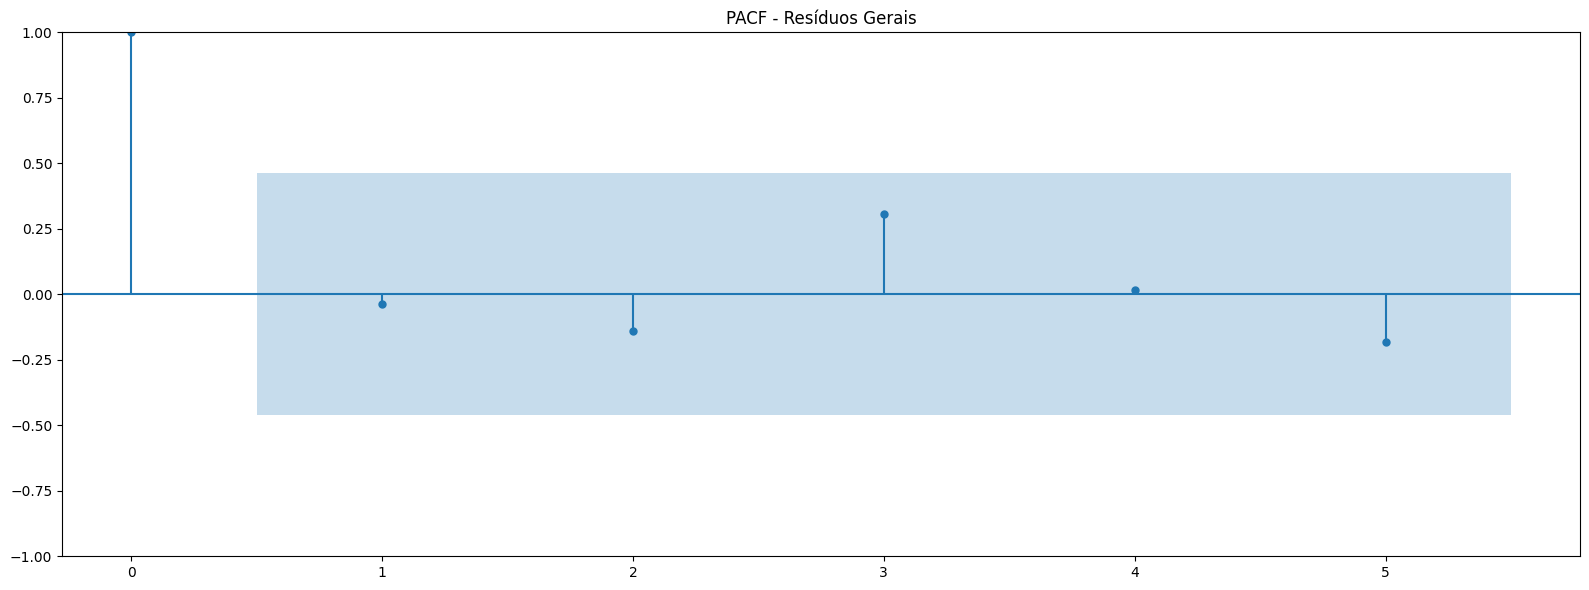

In [118]:
# PACF - Dos residuos 
fig, ax = plt.subplots(figsize=(16, 6))

# Plota o PACF dos resíduos com 5 lags
plot_pacf(df_residuos['resid_LR'], lags=5, ax=ax, title='PACF - Resíduos Gerais')

# Ajusta o layout e exibe o gráfico
plt.tight_layout()
plt.show()




In [119]:
from statsmodels.tsa.ar_model import AutoReg

# Filtrar os dados para o único município
df_municipio = df_residuos.copy()

# Configurar a frequência da série temporal explicitamente
df_municipio = df_municipio.asfreq('W-MON')

# Modelando os resíduos
model_residuos_pacf = AutoReg(df_municipio['resid_LR'], lags=[1, 2]).fit()

# Prevendo os resíduos
df_municipio['resid_pred_pacf'] = model_residuos_pacf.predict(start=2, end=len(df_municipio)-1)

# Ajustando as previsões no DataFrame original
df_residuos['resid_pred_pacf'] = df_municipio['resid_pred_pacf']

# Ajustando as previsões no DataFrame de previsões
df_previsoes['Valor Ajustado_LR_PACF'] = df_previsoes['Valor Previsto_LR'] + df_residuos['resid_pred_pacf']



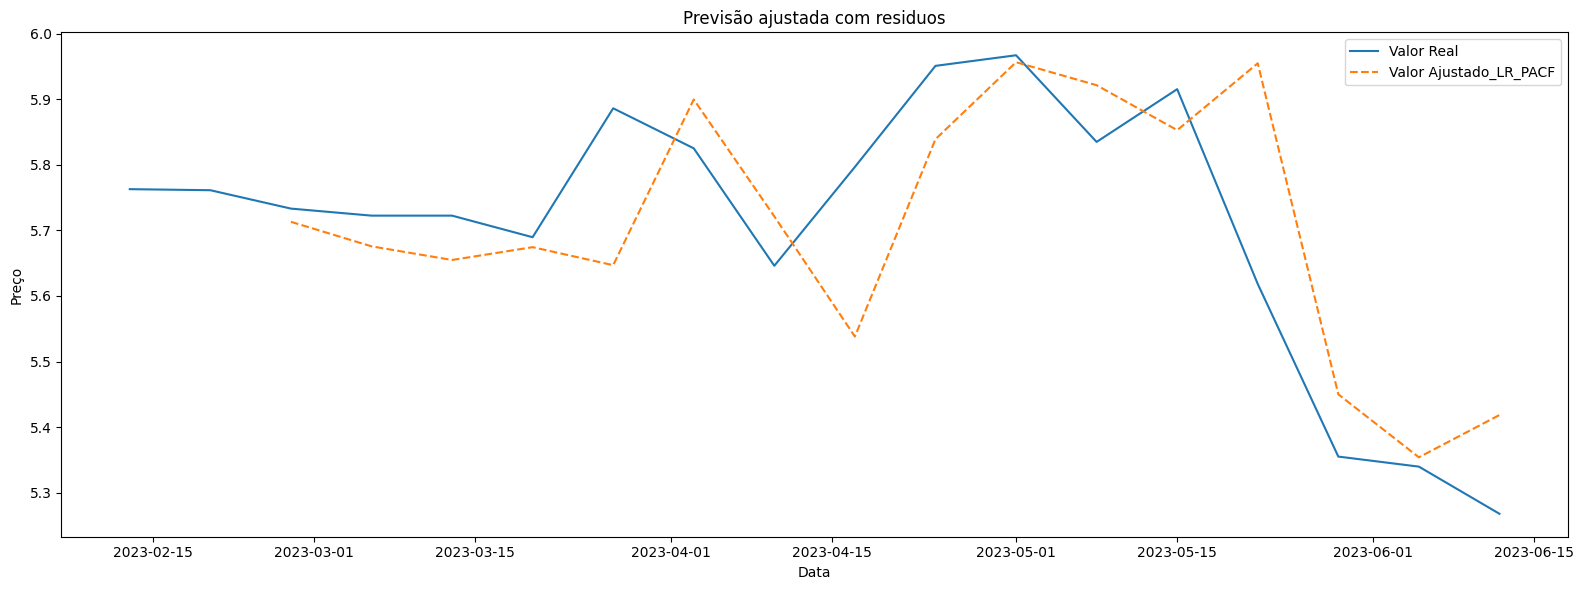

In [120]:
plt.figure(figsize=(16, 6))
plt.plot(df_previsoes['Valor Real'], label='Valor Real')
plt.plot(df_previsoes['Valor Ajustado_LR_PACF'], label='Valor Ajustado_LR_PACF', linestyle='--')
plt.title('Previsão ajustada com residuos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()


plt.tight_layout()
plt.show()

# Modelos ARIMA

In [121]:
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import pmdarima as pm

print("pmdarima version: %s" % pm.__version__)

# Supondo que y_train, X_val_transformed_df, e y_val_series já estão definidos

# Ajustando o tamanho da janela de acordo com os seus dados
window_size =  12  # Ajuste conforme necessário
step = 5

# Configuração para a validação cruzada com SlidingWindowForecastCV
cv = model_selection.SlidingWindowForecastCV(window_size=window_size, step=step, h=1)

# Usando auto_arima com parâmetros ajustados
auto_arima_model = pm.auto_arima(
    y_train.values.ravel(),  # Usando a série temporal original
    start_p=0, start_q=0,    # Começando com valores menores
    max_p=2, max_q=1,        # Limitando os valores máximos
    seasonal=True,
    m=5,  # Ajustando sazonalidade para 4 (ou 8, dependendo dos seus dados)
    start_P=0, start_Q=0,
    max_P=1, max_Q=1,        # Limitando as ordens sazonais
    d=1, D=1,                # Reduzindo a ordem das diferenças
    trace=True,
    error_action='raise',    # Alterar para raise para ver o erro completo
    suppress_warnings=True,
    stepwise=True
)

# Executando a validação cruzada com o modelo selecionado automaticamente
auto_arima_cv_scores = model_selection.cross_val_score(
    auto_arima_model, y_train.values.ravel(), scoring='mean_squared_error', cv=cv, verbose=2)

# Exibindo os scores obtidos
print("Auto-ARIMA CV MSE scores: {}".format(auto_arima_cv_scores.tolist()))

# Calculando o erro médio (MSE) para o modelo selecionado
auto_arima_average_error = np.average(auto_arima_cv_scores)
print("Lowest average MSE for Auto-ARIMA: {}".format(auto_arima_average_error))

# Ajustando o modelo ARIMA encontrado nos dados completos de treinamento
auto_arima_model.fit(y_train.values.ravel())

# Fazendo previsões no conjunto de validação
y_pred_auto_arima = auto_arima_model.predict(n_periods=len(X_val_transformed_df))

# Calculando o MSE final no conjunto de validação
mse_auto_arima = mean_squared_error(y_val_series, y_pred_auto_arima)
print(f"MSE final para o modelo Auto-ARIMA: {mse_auto_arima}")

# Ajustando as previsões no DataFrame original
df_previsoes['Valor Previsto_ARIMA'] = y_pred_auto_arima

# Calculando os resíduos
df_residuos['resid_ARIMA'] = df_previsoes['Valor Real'].subtract(df_previsoes['Valor Previsto_ARIMA'])
# Melhor valor pra seasonalidade é 5


pmdarima version: 2.0.4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-111.504, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-169.141, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=-192.635, Time=0.74 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=-153.177, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[5]             : AIC=-190.682, Time=0.62 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=-176.324, Time=0.25 sec
 ARIMA(0,1,0)(0,1,1)[5]             : AIC=-162.148, Time=0.30 sec
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=-190.718, Time=0.60 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=-189.552, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[5] intercept   : AIC=-191.144, Time=0.65 sec

Best model:  ARIMA(0,1,1)(0,1,1)[5]          
Total fit time: 3.833 seconds
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................

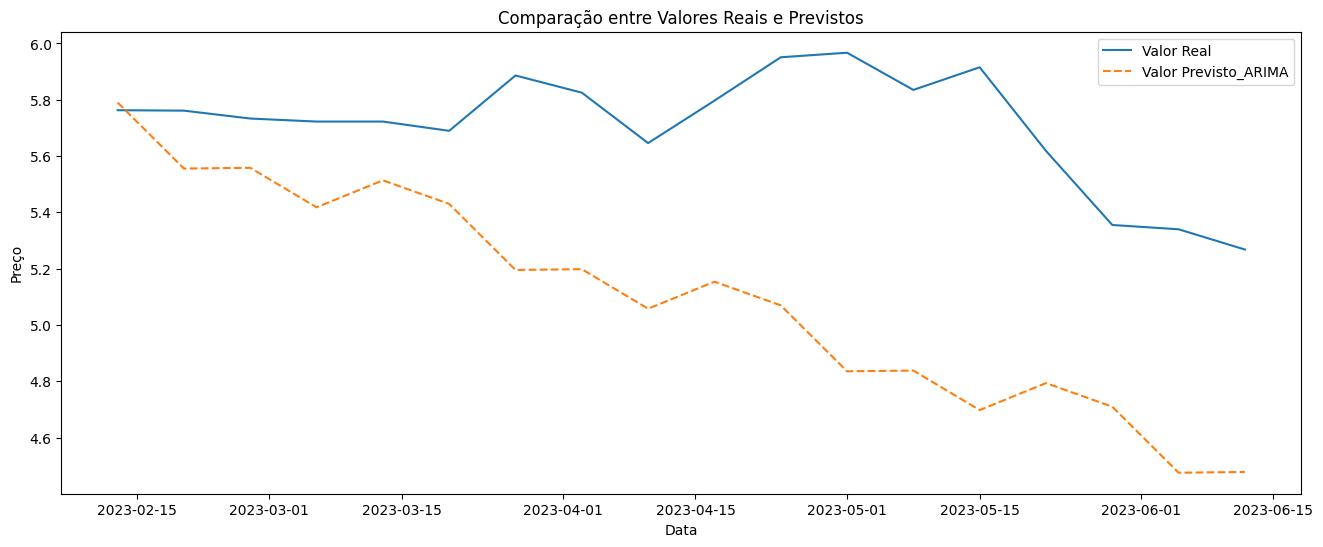

In [122]:
# Plotando os resultados
plt.figure(figsize=(16, 6))
plt.plot(df_previsoes['Valor Real'], label='Valor Real')
plt.plot(df_previsoes['Valor Previsto_ARIMA'], label='Valor Previsto_ARIMA', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

## Residuos do Modelo

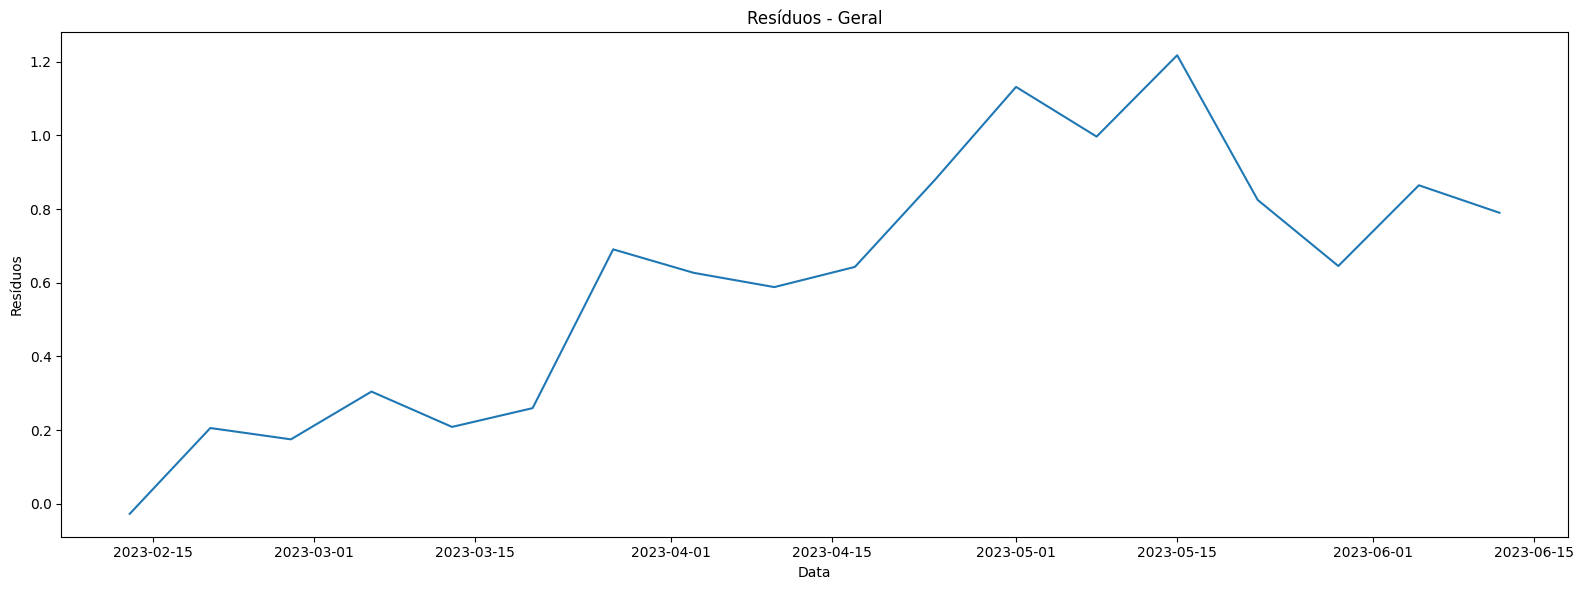

In [123]:
df_residuos['resid_ARIMA'] = df_previsoes['Valor Real'].subtract(df_previsoes['Valor Previsto_ARIMA'])


plt.figure(figsize=(16, 6))
plt.plot(df_residuos[['resid_ARIMA']], label='Valores de Residuos')
plt.title("Resíduos - Geral")
plt.xlabel('Data')
plt.ylabel('Resíduos')

plt.tight_layout()
plt.show()


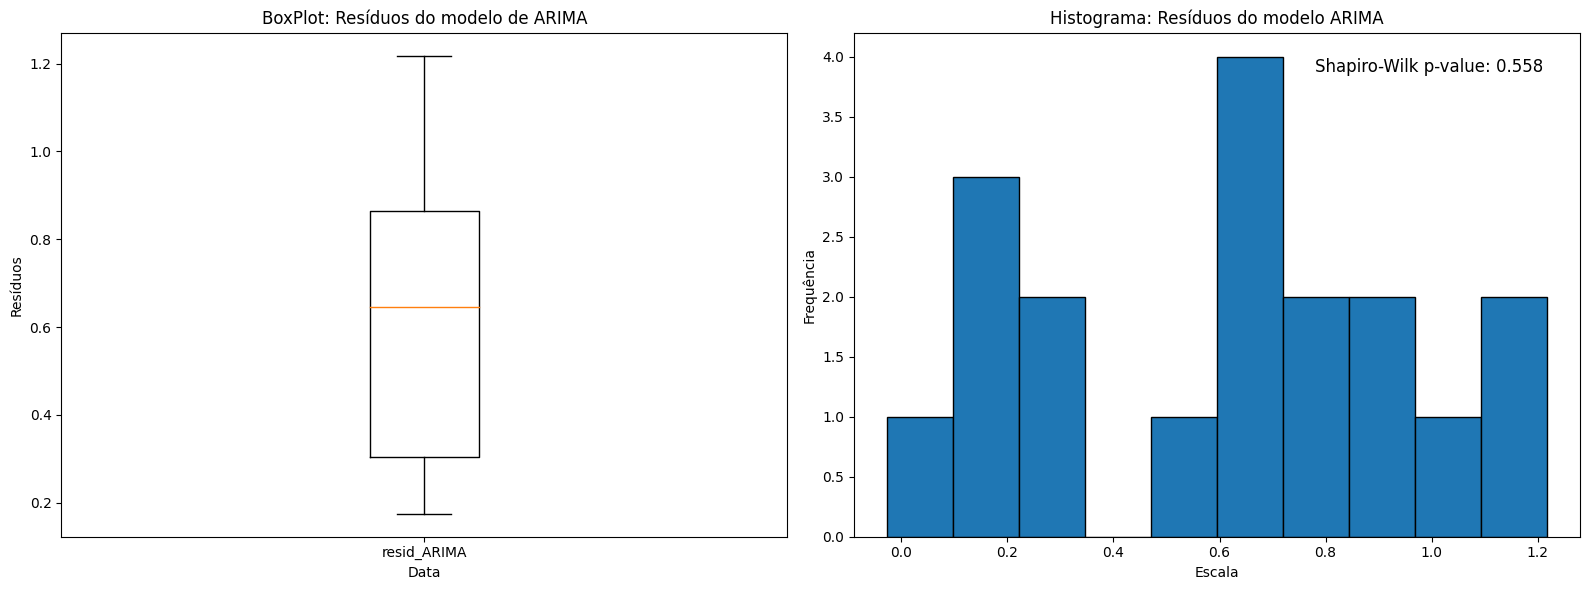

In [124]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Calcular os resíduos

# Criar uma figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotar o boxplot no primeiro subplot
axes[0].boxplot(df_residuos[['resid_ARIMA']].iloc[1:, :], labels=['resid_ARIMA'])
axes[0].set_title("BoxPlot: Resíduos do modelo de ARIMA")
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Resíduos')

# Plotar o histograma no segundo subplot
df_residuos['resid_ARIMA'].plot(kind='hist', ax=axes[1], edgecolor='black')
axes[1].set_title("Histograma: Resíduos do modelo ARIMA")
axes[1].set_xlabel('Escala')
axes[1].set_ylabel('Frequência')

# Realizar o teste de Shapiro-Wilk e adicionar o valor p ao histograma
stat, p_value = shapiro(df_residuos['resid_ARIMA'].dropna())
axes[1].text(0.95, 0.95, f'Shapiro-Wilk p-value: {p_value:.3f}', transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()


## Modelagem dos residuos

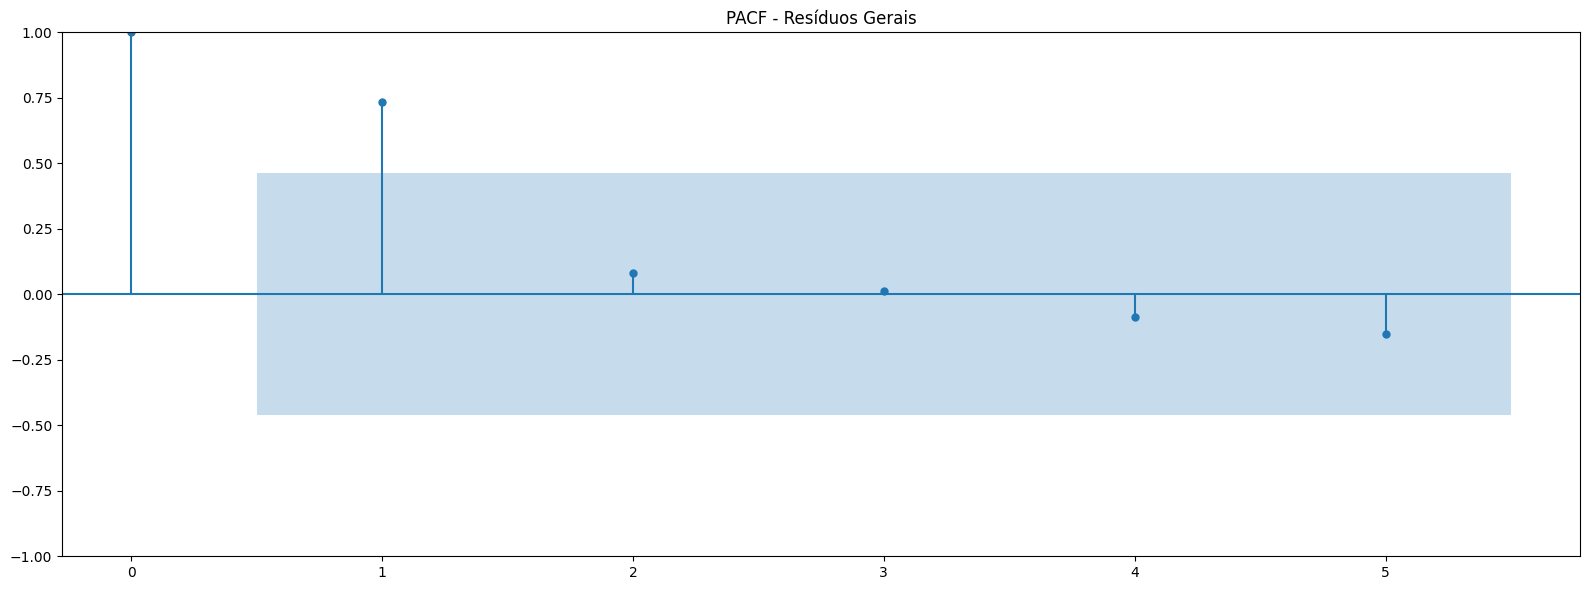

In [125]:

fig, ax = plt.subplots(figsize=(16, 6))

plot_pacf(df_residuos['resid_ARIMA'], lags=5,ax=ax, title='PACF - Resíduos Gerais')

# Ajustando o layout para não sobrepor os subplots
plt.tight_layout()
plt.show()



In [126]:
'''import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Dicionário para armazenar modelos e previsões para cada município
modelos_residuos = {}
previsoes_ajustadas = {}

# Iterar sobre cada município
for municipio in df_residuos['Municipio'].unique():
    # Filtrar os dados para o município atual
    df_municipio = df_residuos[df_residuos['Municipio'] == municipio].copy()
    
    # Configurar a frequência da série temporal explicitamente
    df_municipio = df_municipio.asfreq('W-MON')
    
    # Criar lag dos resíduos para usar como feature
    df_municipio['lag_1'] = df_municipio['resid_ARIMA'].shift(1)
    df_municipio['lag_2'] = df_municipio['resid_ARIMA'].shift(2)
    
    # Remover valores NaN gerados pelos lags
    df_municipio = df_municipio.dropna()
    
    # Modelando os resíduos usando árvore de decisão
    X = df_municipio[['lag_1', 'lag_2']]
    y = df_municipio['resid_ARIMA']
    
    model_arvore = DecisionTreeRegressor(random_state=42)  # Definindo a árvore de decisão
    model_arvore.fit(X, y)
    
    # Prevendo os resíduos
    df_municipio['resid_pred_arvore'] = model_arvore.predict(X)
    
    # Salvando o modelo e as previsões
    modelos_residuos[municipio] = model_arvore
    previsoes_ajustadas[municipio] = df_municipio['resid_pred_arvore']

# Ajustando as previsões no DataFrame original
df_residuos['resid_pred_arvore'] = df_residuos.apply(
    lambda row: previsoes_ajustadas[row['Municipio']].get(row.name, pd.NA), axis=1
)

# Ajustando as previsões no DataFrame de previsões
df_previsoes['Valor Ajustado_ARIMA_PACF'] = df_previsoes['Valor Previsto_ARIMA'] + df_residuos['resid_pred_arvore']'''



"import pandas as pd\nfrom sklearn.tree import DecisionTreeRegressor\nimport numpy as np\n\n# Dicionário para armazenar modelos e previsões para cada município\nmodelos_residuos = {}\nprevisoes_ajustadas = {}\n\n# Iterar sobre cada município\nfor municipio in df_residuos['Municipio'].unique():\n    # Filtrar os dados para o município atual\n    df_municipio = df_residuos[df_residuos['Municipio'] == municipio].copy()\n    \n    # Configurar a frequência da série temporal explicitamente\n    df_municipio = df_municipio.asfreq('W-MON')\n    \n    # Criar lag dos resíduos para usar como feature\n    df_municipio['lag_1'] = df_municipio['resid_ARIMA'].shift(1)\n    df_municipio['lag_2'] = df_municipio['resid_ARIMA'].shift(2)\n    \n    # Remover valores NaN gerados pelos lags\n    df_municipio = df_municipio.dropna()\n    \n    # Modelando os resíduos usando árvore de decisão\n    X = df_municipio[['lag_1', 'lag_2']]\n    y = df_municipio['resid_ARIMA']\n    \n    model_arvore = DecisionTre

In [128]:

from statsmodels.tsa.ar_model import AutoReg

# Dicionário para armazenar modelos e previsões para cada município
modelos_residuos = {}
previsoes_ajustadas = {}

# Iterar sobre cada município
for municipio in df_residuos['Municipio'].unique():
    # Filtrar os dados para o município atual
    df_municipio = df_residuos[df_residuos['Municipio'] == municipio].copy()
    
    # Configurar a frequência da série temporal explicitamente
    df_municipio = df_municipio.asfreq('W-MON')
    
    # Modelando os resíduos
    model_residuos_pacf = AutoReg(df_municipio['resid_ARIMA'], lags=[1, 2]).fit()
    
    # Prevendo os resíduos
    df_municipio['resid_pred_pacf'] = model_residuos_pacf.predict(start=2, end=len(df_municipio)-1)
    
    # Salvando o modelo e as previsões
    modelos_residuos[municipio] = model_residuos_pacf
    previsoes_ajustadas[municipio] = df_municipio['resid_pred_pacf']

# Ajustando as previsões no DataFrame original
df_residuos['resid_pred_pacf'] = df_residuos.apply(
    lambda row: previsoes_ajustadas[row['Municipio']].get(row.name, pd.NA), axis=1
)

df_previsoes['Valor Ajustado_ARIMA_PACF'] = df_previsoes['Valor Previsto_ARIMA'] + df_residuos['resid_pred_pacf']


In [ ]:
from sklearn.metrics import mean_squared_error

# Supondo que 'Valor Real' está na coluna df_previsoes['Valor Real']

# Calcular o MSE das previsões ajustadas
mse_ajustado = mean_squared_error(df_previsoes['Valor Real'], df_previsoes['Valor Ajustado_ARIMA_PACF'])

# Exibir o MSE
print(f"MSE para o modelo com previsões ajustadas (ARIMA + PACF): {mse_ajustado}")


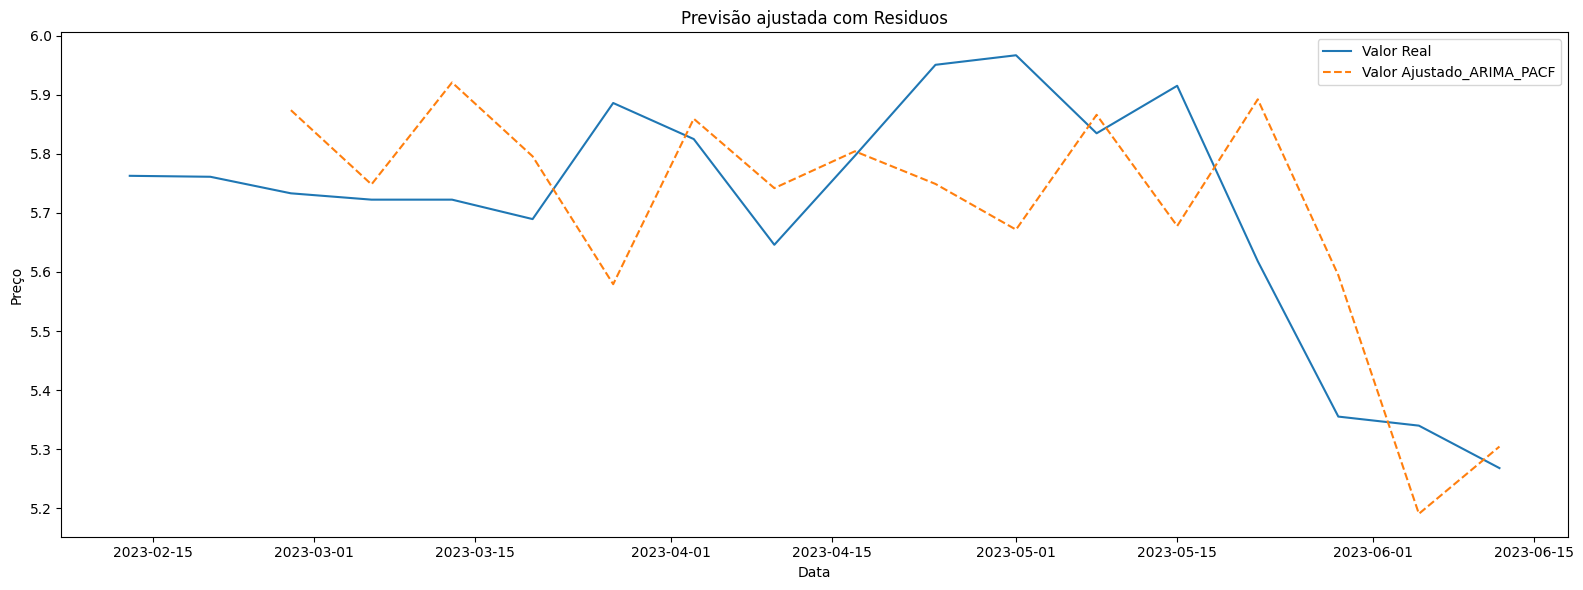

In [80]:
plt.figure(figsize=(16, 6))
plt.plot(df_previsoes['Valor Real'], label='Valor Real')
plt.plot(df_previsoes['Valor Ajustado_ARIMA_PACF'], label='Valor Ajustado_ARIMA_PACF', linestyle='--')
plt.title('Previsão ajustada com Residuos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()


plt.tight_layout()
plt.show()


## Modelo ETS

In [81]:
from sktime.forecasting.ets import AutoETS

# Configurando o modelo ETS com sktime
ets_model = AutoETS(
    seasonal='add',  # Ajustar conforme necessário (pode ser 'add' ou 'mul')
    sp=5,  # Ajustar sazonalidade (período sazonal)
    error='add',    # Erro aditivo
    trend='mul' ,   # Tendência aditiva
    information_criterion = 'bic',
    auto  = True
)

# Executando a validação cruzada com SlidingWindowSplitter
ets_mse_scores = []

for train_idx, test_idx in cv.split(y_train):
    y_train_split, y_test_split = y_train.iloc[train_idx], y_train.iloc[test_idx]
    ets_model.fit(y_train_split)
    y_pred = ets_model.predict(fh=[1])
    mse = mean_squared_error(y_test_split, y_pred)
    ets_mse_scores.append(mse)

# Exibindo os MSEs obtidos na validação cruzada
print("ETS CV MSE scores: ", ets_mse_scores)

# Ajustando o modelo ETS nos dados completos de treinamento
ets_model.fit(y_train)

# Fazendo previsões no conjunto de validação
y_pred_ets = ets_model.predict(fh=np.arange(1, len(y_val) + 1))

# Calculando o MSE final no conjunto de validação
mse_ets = mean_squared_error(y_val_series, y_pred_ets)
print(f"MSE final para o mvodelo ETS: {mse_ets}")

# Ajustando as previsões no DataFrame original
df_previsoes['Valor Previsto_ETS'] = y_pred_ets.values
df_residuos['resid_ETS'] = df_previsoes['Valor Real'].subtract(df_previsoes['Valor Previsto_ETS'])


C:\Users\kaio\AppData\Local\Temp\ipykernel_28684\1553546170.py:4: UserWarning: The user-specified parameters provided alongside auto=True in AutoETS may not be respected. The AutoETS function automatically selects the best model based on the information criterion, ignoring the error, trend, seasonal, and damped_trend parameters when auto=True is set. Please ensure that your intended behavior aligns with the automatic model selection.
  ets_model = AutoETS(
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\skbase\base\_base.py:141: UserWarning: The user-specified parameters provided alongside auto=True in AutoETS may not be respected. The AutoETS function automatically selects the best model based on the information criterion, ignoring the error, trend, seasonal, and damped_trend parameters when auto=True is set. Please ensure that your intended behavior aligns with the automatic model selection.
  self.__init__(**params)
c:\Users\kaio\AppData\Local\Programs\Python

ETS CV MSE scores:  [0.0008110547377406269, 0.001232052634746641, 0.00015352353972040772, 3.392348816043984e-05, 0.0021374175358748965, 0.006949456512756885, 0.0009996063532120023, 0.0008955530884683818, 0.007176663707226208, 0.0008584794949373621, 0.0013821282341471358, 2.9859626213065817e-05, 0.015093915619935014, 0.0005005254700388707, 0.03060481342836119, 1.536034120018108e-05, 0.003879349069131922, 0.00035333933429244614, 8.815058962023895e-06, 9.477411324891972e-12, 0.002914052913930156, 0.23170081003136342, 1.1041357123121297e-11, 0.005660954117735206, 0.00013519729484453308, 0.00029218851244489433, 8.836971035807142e-05, 0.001567107450894523, 0.01117999668762405, 0.2844986891001117]


c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Pyth

MSE final para o modelo ETS: 0.23178529151896432


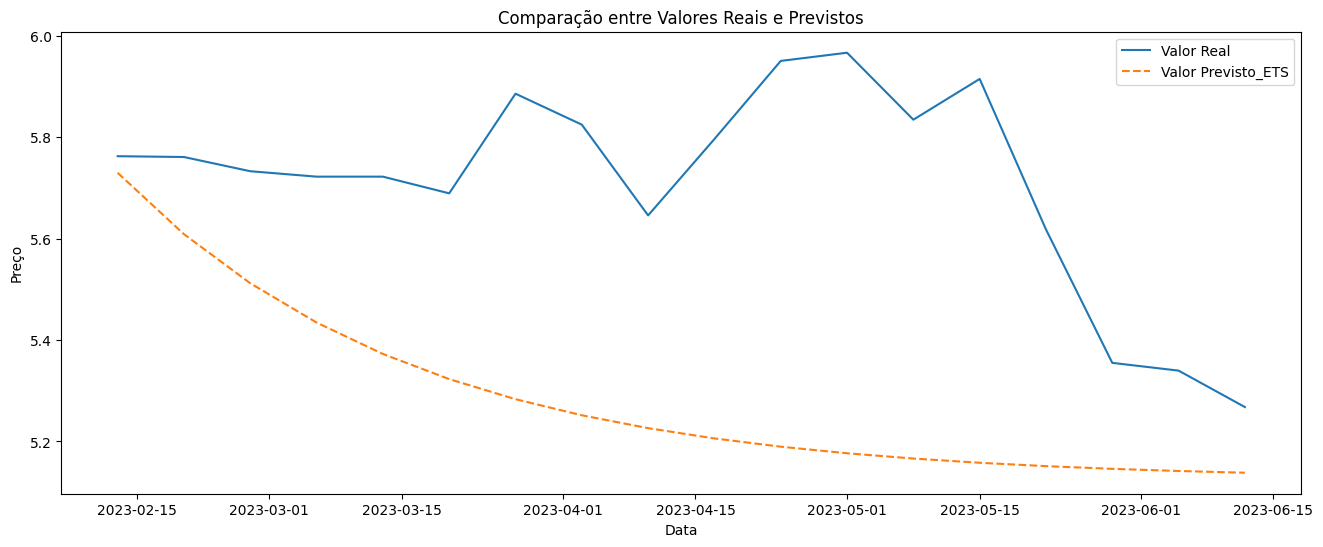

In [82]:
# Plotando os resultados
plt.figure(figsize=(16, 6))
plt.plot(df_previsoes['Valor Real'], label='Valor Real')
plt.plot(df_previsoes['Valor Previsto_ETS'], label='Valor Previsto_ETS', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

## Residuos do Modelo

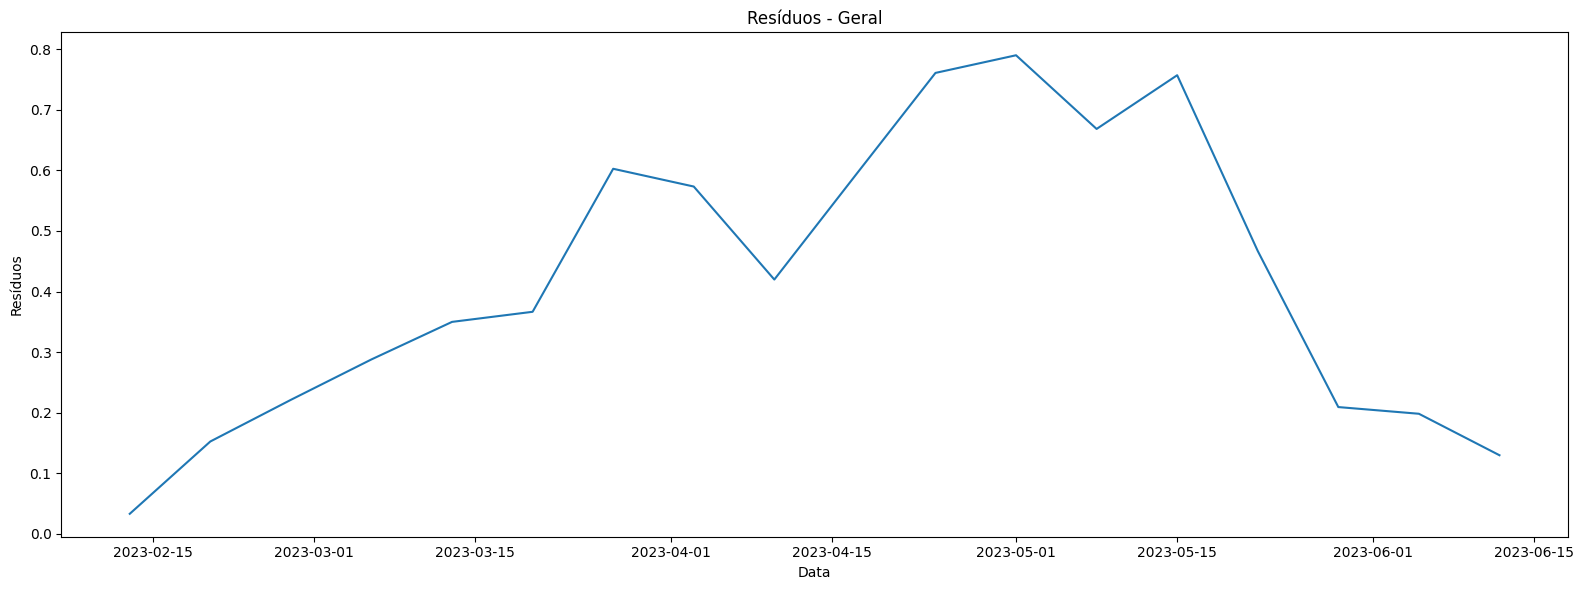

In [83]:
df_residuos['resid_ARIMA'] = df_previsoes['Valor Real'].subtract(df_previsoes['Valor Previsto_ETS'])


plt.figure(figsize=(16, 6))
plt.plot(df_residuos[['resid_ETS']], label='Valores de Residuos')
plt.title("Resíduos - Geral")
plt.xlabel('Data')
plt.ylabel('Resíduos')

plt.tight_layout()
plt.show()


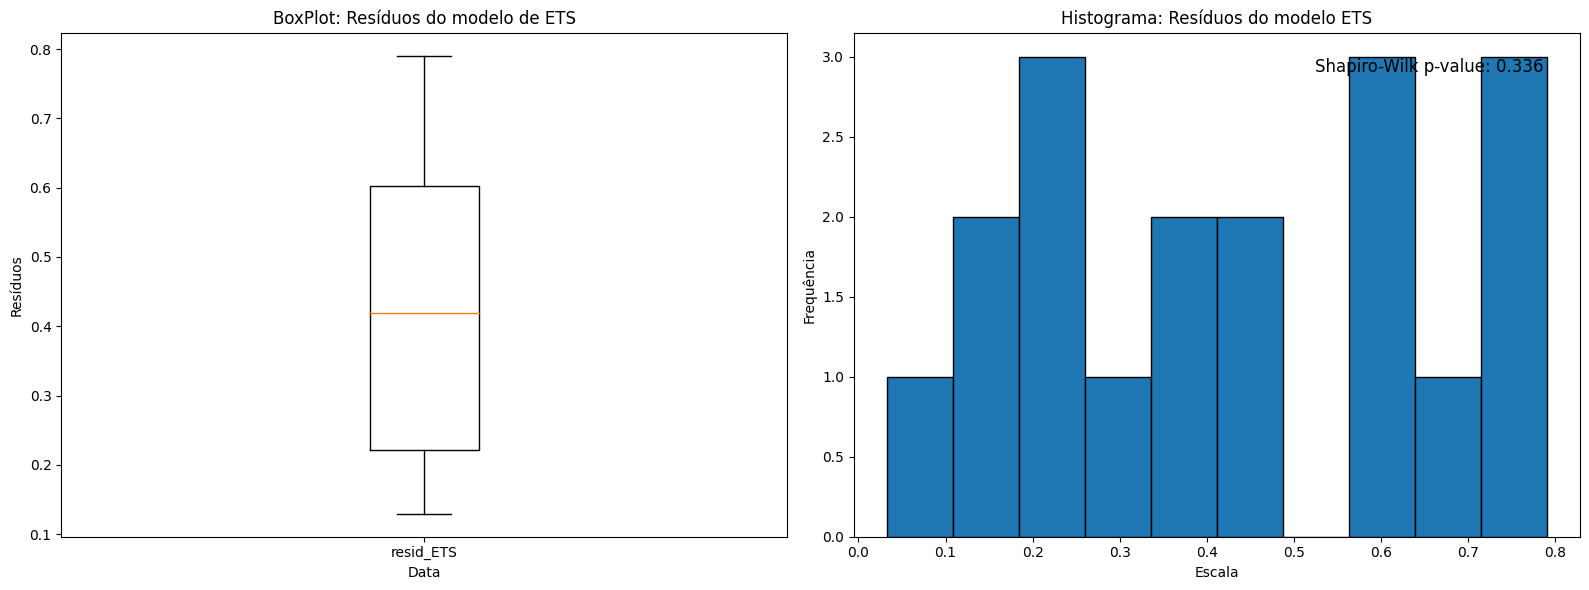

In [84]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Calcular os resíduos

# Criar uma figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotar o boxplot no primeiro subplot
axes[0].boxplot(df_residuos[['resid_ETS']].iloc[1:, :], labels=['resid_ETS'])
axes[0].set_title("BoxPlot: Resíduos do modelo de ETS")
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Resíduos')

# Plotar o histograma no segundo subplot
df_residuos['resid_ETS'].plot(kind='hist', ax=axes[1], edgecolor='black')
axes[1].set_title("Histograma: Resíduos do modelo ETS")
axes[1].set_xlabel('Escala')
axes[1].set_ylabel('Frequência')

# Realizar o teste de Shapiro-Wilk e adicionar o valor p ao histograma
stat, p_value = shapiro(df_residuos['resid_ETS'].dropna())
axes[1].text(0.95, 0.95, f'Shapiro-Wilk p-value: {p_value:.3f}', transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()


## Modelagem dos residuos

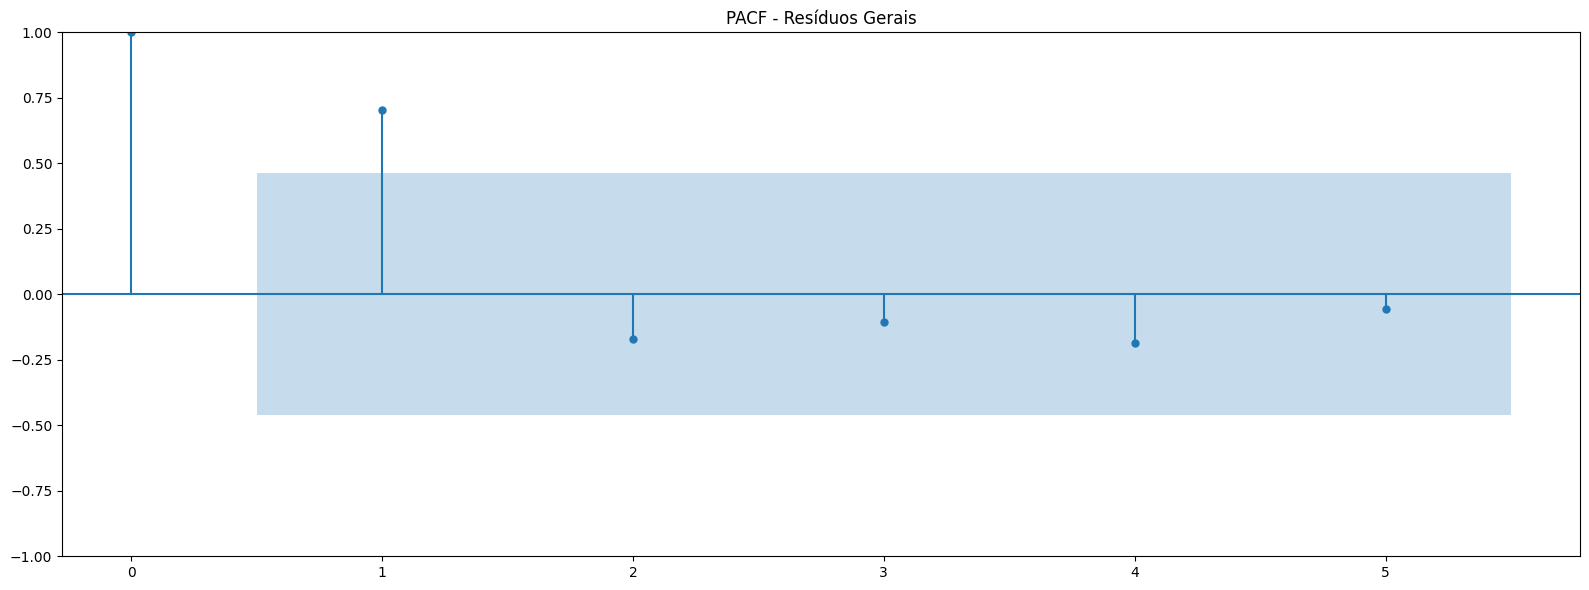

In [85]:
fig, ax = plt.subplots(figsize=(16, 6))

plot_pacf(df_residuos['resid_ETS'], lags=5,ax=ax, title='PACF - Resíduos Gerais')

# Ajustando o layout para não sobrepor os subplots
plt.tight_layout()
plt.show()


In [86]:
'''import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Dicionário para armazenar modelos e previsões para cada município
modelos_residuos = {}
previsoes_ajustadas = {}

# Iterar sobre cada município
for municipio in df_residuos['Municipio'].unique():
    # Filtrar os dados para o município atual
    df_municipio = df_residuos[df_residuos['Municipio'] == municipio].copy()
    
    # Configurar a frequência da série temporal explicitamente
    df_municipio = df_municipio.asfreq('W-MON')
    
    # Criar lag dos resíduos para usar como feature
    df_municipio['lag_1'] = df_municipio['resid_ARIMA'].shift(1)
    df_municipio['lag_2'] = df_municipio['resid_ARIMA'].shift(2)
    
    # Remover valores NaN gerados pelos lags
    df_municipio = df_municipio.dropna()
    
    # Modelando os resíduos usando árvore de decisão
    X = df_municipio[['lag_1', 'lag_2']]
    y = df_municipio['resid_ARIMA']
    
    model_arvore = DecisionTreeRegressor(random_state=42)  # Definindo a árvore de decisão
    model_arvore.fit(X, y)
    
    # Prevendo os resíduos
    df_municipio['resid_pred_arvore'] = model_arvore.predict(X)
    
    # Salvando o modelo e as previsões
    modelos_residuos[municipio] = model_arvore
    previsoes_ajustadas[municipio] = df_municipio['resid_pred_arvore']

# Ajustando as previsões no DataFrame original
df_residuos['resid_pred_arvore'] = df_residuos.apply(
    lambda row: previsoes_ajustadas[row['Municipio']].get(row.name, pd.NA), axis=1
)

# Ajustando as previsões no DataFrame de previsões
df_previsoes['Valor Ajustado_ARIMA_PACF'] = df_previsoes['Valor Previsto_ARIMA'] + df_residuos['resid_pred_arvore']'''



"import pandas as pd\nfrom sklearn.tree import DecisionTreeRegressor\nimport numpy as np\n\n# Dicionário para armazenar modelos e previsões para cada município\nmodelos_residuos = {}\nprevisoes_ajustadas = {}\n\n# Iterar sobre cada município\nfor municipio in df_residuos['Municipio'].unique():\n    # Filtrar os dados para o município atual\n    df_municipio = df_residuos[df_residuos['Municipio'] == municipio].copy()\n    \n    # Configurar a frequência da série temporal explicitamente\n    df_municipio = df_municipio.asfreq('W-MON')\n    \n    # Criar lag dos resíduos para usar como feature\n    df_municipio['lag_1'] = df_municipio['resid_ARIMA'].shift(1)\n    df_municipio['lag_2'] = df_municipio['resid_ARIMA'].shift(2)\n    \n    # Remover valores NaN gerados pelos lags\n    df_municipio = df_municipio.dropna()\n    \n    # Modelando os resíduos usando árvore de decisão\n    X = df_municipio[['lag_1', 'lag_2']]\n    y = df_municipio['resid_ARIMA']\n    \n    model_arvore = DecisionTre

In [87]:

from statsmodels.tsa.ar_model import AutoReg

# Dicionário para armazenar modelos e previsões para cada município
modelos_residuos = {}
previsoes_ajustadas = {}

# Iterar sobre cada município
for municipio in df_residuos['Municipio'].unique():
    # Filtrar os dados para o município atual
    df_municipio = df_residuos[df_residuos['Municipio'] == municipio].copy()
    
    # Configurar a frequência da série temporal explicitamente
    df_municipio = df_municipio.asfreq('W-MON')
    
    # Modelando os resíduos
    model_residuos_pacf = AutoReg(df_municipio['resid_ETS'], lags=[1, 2]).fit()
    
    # Prevendo os resíduos
    df_municipio['resid_pred_pacf'] = model_residuos_pacf.predict(start=2, end=len(df_municipio)-1)
    
    # Salvando o modelo e as previsões
    modelos_residuos[municipio] = model_residuos_pacf
    previsoes_ajustadas[municipio] = df_municipio['resid_pred_pacf']

# Ajustando as previsões no DataFrame original
df_residuos['resid_pred_pacf'] = df_residuos.apply(
    lambda row: previsoes_ajustadas[row['Municipio']].get(row.name, pd.NA), axis=1
)

df_previsoes['Valor Ajustado_ETS_PACF'] = df_previsoes['Valor Previsto_ETS'] + df_residuos['resid_pred_pacf']


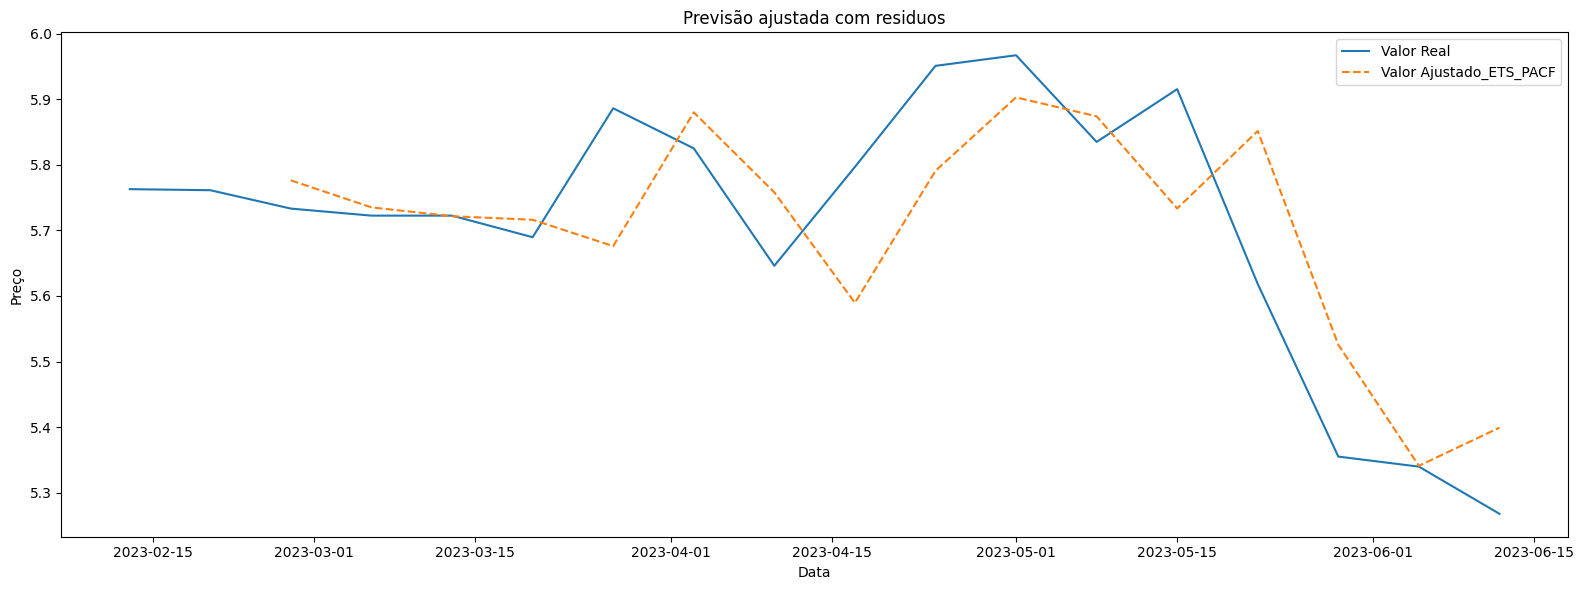

In [88]:
plt.figure(figsize=(16, 6))
plt.plot(df_previsoes['Valor Real'], label='Valor Real')
plt.plot(df_previsoes['Valor Ajustado_ETS_PACF'], label='Valor Ajustado_ETS_PACF', linestyle='--')
plt.title('Previsão ajustada com residuos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()


plt.tight_layout()
plt.show()


## ETS modelo 2

In [89]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.metrics import mean_squared_error
import numpy as np

# Configurando o modelo ETS
ets_model = AutoETS(
     # Ajustar conforme necessário (pode ser 'add' ou 'mul')
    sp=5,  # Ajustar sazonalidade (período sazonal)
      # Tendência multiplicativa
    information_criterion='aicc',
    auto=True
)

# Configurando o splitter para SlidingWindowCrossValidation
cv = SlidingWindowSplitter(fh=[1], window_length=12, step_length=3)  # janela de 52 semanas e previsão de 1 passo à frente

ets_mse_scores = []

# Validação cruzada para prever um passo à frente em cada iteração
for train_idx, test_idx in cv.split(y_train):
    y_train_split, y_test_split = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # Ajuste o modelo nos dados de treino da janela atual
    ets_model.fit(y_train_split)
    
    # Preveja o próximo ponto
    y_pred = ets_model.predict(fh=[1])
    
    # Calcule o erro MSE para este passo à frente
    mse = mean_squared_error(y_test_split, y_pred)
    ets_mse_scores.append(mse)

# Exibindo os MSEs obtidos na validação cruzada
print("ETS CV MSE scores: ", ets_mse_scores)

# Ajustando o modelo ETS nos dados completos de treinamento
ets_model.fit(y_train)

# Fazendo previsões no conjunto de validação
y_pred_ets = ets_model.predict(fh=np.arange(1, len(y_val) + 1))

# Calculando o MSE final no conjunto de validação
mse_ets = mean_squared_error(y_val_series, y_pred_ets)
print(f"MSE final para o modelo ETS: {mse_ets}")

# Ajustando as previsões no DataFrame original
df_previsoes['Valor Previsto_ETS'] = y_pred_ets.values
df_residuos['resid_ETS'] = df_previsoes['Valor Real'].subtract(df_previsoes['Valor Previsto_ETS'])


c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Pyth

ETS CV MSE scores:  [0.00041284076040691954, 0.025117320980996217, 0.002423493450440435, 0.021923037431653816, 0.02637545735150035, 3.392348816043984e-05, 9.330592474098402e-07, 0.0007559071870407838, 0.003974086547158535, 0.019556493730816676, 0.0009996063532120023, 0.003087307987433109, 0.013824348650841528, 0.0224461381140257, 0.00030334331714684055, 0.0008584794949373621, 0.006433925651496961, 0.0, 0.00013752474854743316, 9.560796872774608e-06, 0.015093915619935014, 0.00023761616499530486, 0.00018960443380018402, 0.053309050086209266, 1.910460459842938e-05, 1.536034120018108e-05, 2.3935092711475718e-05, 0.0003566839801422755, 6.670813505841602e-05, 5.9478061139874924e-05, 8.815058962023895e-06, 0.018292586215373895, 0.0004441876387940613, 7.264620847346727e-05, 2.297145141015072e-05, 0.08623455286278155, 0.008355207731037692, 0.00010951310965158963, 0.0009789026501515778, 0.012811611389741809, 0.00013519729484453308, 0.0014134741783621248, 0.3282818159785355, 0.0005063865845333185,

c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Pyth

MSE final para o modelo ETS: 0.23178529151896432


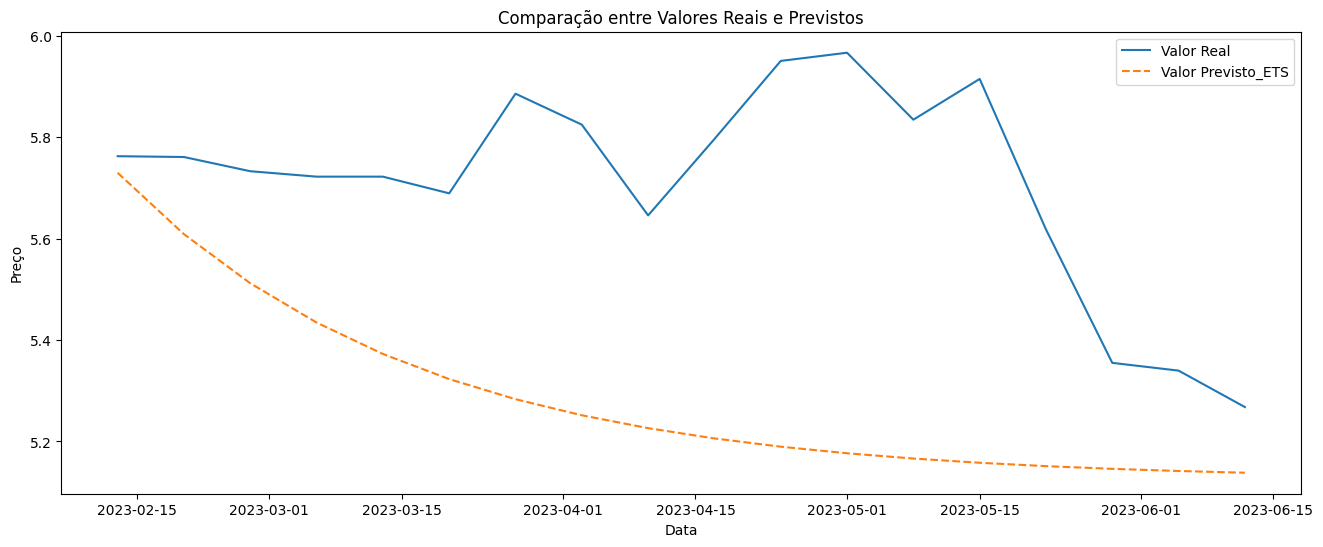

In [90]:
# Plotando os resultados
plt.figure(figsize=(16, 6))
plt.plot(df_previsoes['Valor Real'], label='Valor Real')
plt.plot(df_previsoes['Valor Previsto_ETS'], label='Valor Previsto_ETS', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()